**Preprocesamiento Dataset Foros Moodle**

In [ ]:
!python -m spacy download es_core_news_sm
!pip install fasttext

%matplotlib inline
from matplotlib import pyplot as plt
import csv
import warnings
import lxml.html.clean
warnings.filterwarnings('ignore')
import re
from re import sub
import multiprocessing
from textblob import TextBlob
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
import nltk
import nltk.data
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk import FreqDist
from bs4 import BeautifulSoup
import re, string, unicodedata
import spacy
from sklearn.metrics import accuracy_score

from nltk.tokenize.toktok import ToktokTokenizer
import collections

from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image

from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')

nltk.download('stopwords') 
stop_words =stopwords.words('spanish')




     |████████████████████████████████| 16.2 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2) Importar los datos csv en en un dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

header_list = ["texto", "sentiment"]
train_data=pd.read_csv('/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/moodle.csv', delimiter='|', encoding='utf-8',engine='python',header=None,names=header_list)

Mounted at /content/gdrive/


3) Análisis preeliminar de datos

In [ ]:
#Explorar 5 primeras filas
train_data.sample(5)

,texto,sentiment
30683,"<p>Las personas tenemos varias formas de aprender, pero bien es cierto que depende también de la información a tratar, ya que, para algunos de nosotros se nos dificulta porque hemos estado acostumbrados a una rutina de aprendizaje muy diferente, en este video nos damos cuenta que cada persona posee una capacidad distinta para aprender, pero aun con esto, logramos adquirir la información que nos desean transmitir. El aprendizaje esta en cada persona y en sus ganas de tener nuevos conocimientos en su vida personal, académica, laboral y es bien dicho que el que quiere lo logra. </p><p> </p><p>https://www.youtube.com/watch?v=A8WpqhODdBI</p>",0
51,"<p>aprender y manejar el idioma, enriquecer el vocabulario</p>",0
14073,"<div class=""text_to_html"">Bienvenida Daniela!!</div>",0
9716,"<div class=""text_to_html"">Los modelos pedagógicos se caracterizan por ser dinámicos, flexibles y adaptables a los contextos sociales, razón por la cual los actuales modelos pedagógicos con su fundamentación teórica, vienen contribuyendo al afianzamiento de una educación mediada por la tecnología, porque esos modelos y teorías pedagógicas se transforman deductivamente en unos referentes que guían la acción en el aula e inductivamente se materializan mediante estrategias didácticas direccionadas a alcanzar los fines del aprendizaje, y es aquí precisamente, donde las prácticas educativas se interrelacionan con las innovaciones tecnológicas.<br />Además, las diferentes teorías sobre modelos pedagógicos dan respuestas a los cambios contextuales y momentos coyunturales desde diferentes perspectivas psicológicas, filosóficas, antropológicas, económicas, políticas y tecnológicas, de modo que se dispone de una amplia gama de posibilidades ante diferentes propósitos sociales.</div>",0
8098,"<div class=""text_to_html"">Realmente es muy satisfactorio ver la claridad que tienes sobre esta hermosa profesión, el campo de la pediatría te dará la oportunidad de transformar vidas de una forma maravillosa!!!</div>",0


In [ ]:
train_data.dtypes

texto        object
sentiment    int64 
dtype: object

In [ ]:
#Explorar 5 ultimas filas
train_data.tail(5)

texto  \
34404  <p>Buenos días</p><p>Hoy nos encontraremos a las 2pm para resolver algunas dudas del procedimiento de sustentación y entrega del documento definitivo para culminar el trabajo de grado</p>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
#Revisar estructura del dataset
train_data.dtypes

texto        object
sentiment    int64 
dtype: object

In [ ]:
#Análisis de datos
# Número total de filas y columnas
print(f"*****El dataset contiene:{train_data.shape[0]} filas y {train_data.shape[1]} columnas *****")
#Filas que tienen datos duplicados
duplicate_rows_td = train_data[train_data.duplicated()]
print("*****Filas duplicadas", duplicate_rows_td.shape[0])
#Número de filas antes de eliminar duplicados
print(f"*****Número de filas antes de eliminar duplicados ***** \n{train_data.count()}", "\n")
#Eliminar duplicados
train_data = train_data.drop_duplicates()
#Número de filas antes de eliminar duplicados
print(f"*****Número de filas después de eliminar duplicados ***** \n{train_data.count()}", "\n")
print(f"*****Datos nulos en alguna columna ***** \n{train_data.isnull().sum()}", "\n")
#Eliminar Nulos
train_data = train_data.dropna() 
print(f"*****Luego de eliminar nulos ***** \n{train_data.count()}", "\n")
#Filtrar solo aquellos que tienen texto >5 caracteres
train_data = train_data[(train_data['texto'].apply(len) >10)]

*****El dataset contiene:34409 filas y 2 columnas *****
*****Filas duplicadas 0
*****Número de filas antes de eliminar duplicados ***** 
texto        34409
sentiment    34409
dtype: int64 

*****Número de filas después de eliminar duplicados ***** 
texto        34409
sentiment    34409
dtype: int64 

*****Datos nulos en alguna columna ***** 
texto        0
sentiment    0
dtype: int64 

*****Luego de eliminar nulos ***** 
texto        34409
sentiment    34409
dtype: int64 



In [ ]:
#Funciones para limpiar el texto
#!pip install spacy
#!python -m spacy download es_core_news_sm
stemmer = SnowballStemmer("spanish")
import fasttext
path_to_pretrained_model = '/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)
stop_words.extend(['si', 'tambien', 'asi', 'debe', 'tener','cada','ademas','parte','ser','ma','mismo','mas'])  

#Funcion para remover tags html
def html_remover(data):
  beauti = BeautifulSoup(data,'html.parser')
  return beauti.get_text()

#Funcion para Remover URLs
def url_remover(data):
  return re.sub(r'https\S','',data)

def clean_text(text):
  #Convertir a minúsculas
  text = text.lower()
  #LLamar funciones para remover html y urls
  text= html_remover(text)
  text = url_remover(text) 
  #Eliminar texto entre corchetes, signos de puntuacion y numeros
  text = re.sub('\[.*?¿\]\%', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\w*\d\w*', '', text)
  text = re.sub('[‘’“”…«»]', '', text)
  text = re.sub('\n','', text)
  

  #Eliminar tildes y diacriticas
  text = re.sub('á', 'a', text)
  text = re.sub('é', 'e', text)
  text = re.sub('í', 'i', text)
  text = re.sub('ó', 'o', text)
  text = re.sub('ú', 'u', text)
  text = re.sub('ü', 'u', text)
  text = re.sub('ñ', 'n', text)
  text = re.sub('¿', '', text)

  return text

def tokenize_text(text):
  text = word_tokenize(text) 
  text = [word for word in text if word not in stop_words]
  return text

def lang_detect(text):
  languages = ["spanish","english","dutch","german","italian","portuguese","turkish","danish","french"]
  lang_count = {}
  tokens = nltk.tokenize.word_tokenize(text)
  tokens = [t.strip().lower() for t in tokens]
  for lang in languages:
    stop_words_l = str(nltk.corpus.stopwords.words(lang))
    lang_count[lang] = 0
    for word in tokens:
      if word in stop_words_l:
        lang_count[lang] += 1
  detected_language = max(lang_count, key=lang_count.get)
  return detected_language

def lang_detect_2(text):
  nlp = spacy.load('en')  # 1
  nlp.add_pipe(LanguageDetector(), name='language_detector', last=True) #2
  doc = nlp(text) #3
  detect_language = doc._.language #4
  return(detect_language)

def lang_detect_3(text):
  lang=fmodel.predict(text)  # ([['__label__en']], [array([0.9331119], dtype=float32)]
  return lang[0][0].replace('__label__', '')

4) Ejecutar limpieza de texto y detección de idioma

In [ ]:
#Ejecutar limpieza de datos
train_data['cleaned'] = train_data['texto'].apply(clean_text)

In [ ]:
#Explorar los datos una vez ejecutadas las funciones de limpieza
train_data.sample(3)

,texto,sentiment,cleaned
31893,"<p>Cordial saludo.</p><p>Mi nombre es Olimpo Coneo Sarmiento, natural del municipio de Soplaviento, Bolívar.</p><p>Actualmente resido en Buenaventura, Valle, donde ejerzo labor pastoral. Soy licenciado en Lenguas Modernas, egresado de la Universidad del Atlántico, y desde hace 26 años me he dedicado al ministerio pastoral, en lo cual he tratado continuamente con las familias de mi comunidad religiosa.</p><p>En el curso de Pensamiento Sistémico espero adquirir más herramientas y conocimientos formales aplicables en mi tarea de pastorear a los miembros de estas familias.</p><p> </p>",0,cordial saludomi nombre es olimpo coneo sarmiento natural del municipio de soplaviento bolivaractualmente resido en buenaventura valle donde ejerzo labor pastoral soy licenciado en lenguas modernas egresado de la universidad del atlantico y desde hace anos me he dedicado al ministerio pastoral en lo cual he tratado continuamente con las familias de mi comunidad religiosaen el curso de pensamiento sistemico espero adquirir mas herramientas y conocimientos formales aplicables en mi tarea de pastorear a los miembros de estas familias
19580,<p>EL BUEN GOBIERNO</p><p> </p><p>Conforme al documento de lectura la cultura empresarial en algunas empresas es de tipo autoritaria donde el dueño ejerce poder absoluto como reflejo del “Gobierno Corporativo” similar al que se ve reflejado en la infraestructura vial.</p><p>Establece también que existe una diferencia entre lo que es la Ley respecto del Código del buen gobierno</p>,0,el buen gobierno conforme al documento de lectura la cultura empresarial en algunas empresas es de tipo autoritaria donde el dueno ejerce poder absoluto como reflejo del gobierno corporativo similar al que se ve reflejado en la infraestructura vialestablece tambien que existe una diferencia entre lo que es la ley respecto del codigo del buen gobierno
26871,<p>BUENAS TARDES ESTAS SON MIS RESPUESTAS AL FORO #1</p>,0,buenas tardes estas son mis respuestas al foro


In [ ]:
#Detectar texto en otros idiomas idioma
train_data['lang'] = train_data['cleaned'].apply(lang_detect_3)

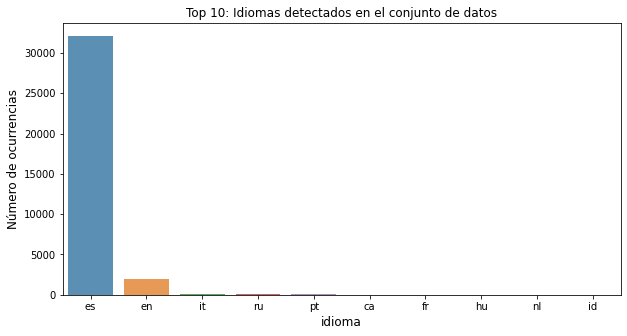

In [ ]:
#Agrupar datos por idioma

lang_count  = train_data["lang"].value_counts()
lang_count = lang_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(lang_count.index, lang_count.values, alpha=0.8)
plt.title('Top 10: Idiomas detectados en el conjunto de datos')
plt.ylabel('Número de ocurrencias', fontsize=12)
plt.xlabel('idioma', fontsize=12)
plt.show()

5) Filtrar solo los de idioma español

In [ ]:
train_data = train_data[(train_data['lang'] == 'es')]
print(f"*****Cantidad de registros luego de filtrar el idioma ***** \n{train_data.count()}", "\n")

*****Cantidad de registros luego de filtrar el idioma ***** 
texto        32102
sentiment    32102
cleaned      32102
lang         32102
dtype: int64 



6) Realizar segundo análisis sobre el texto en español

*****Nube de Palabras ***** 
 



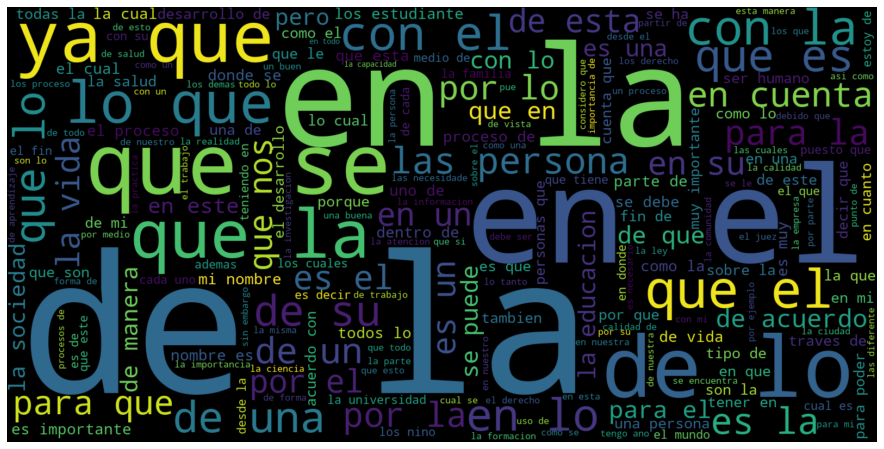

*****2000 palabras mas frecuentes ***** 
[('de', 252275), ('la', 175581), ('que', 162432), ('y', 134223), ('en', 119311), ('el', 117530), ('a', 88428), ('los', 66630), ('se', 65872), ('es', 55493), ('las', 52263), ('un', 46600), ('para', 46486), ('una', 40658), ('por', 40619), ('con', 40445), ('del', 38849), ('como', 34857), ('no', 30212), ('lo', 28986), ('su', 23752), ('al', 22596), ('o', 21215), ('mas', 18083), ('esta', 17808), ('ya', 15237), ('mi', 15041), ('este', 14116), ('ser', 13691), ('son', 13135), ('nos', 11999), ('sus', 11328), ('me', 10918), ('muy', 10307), ('si', 10156), ('personas', 9750), ('vida', 9646), ('manera', 9624), ('donde', 9249), ('cual', 9192), ('puede', 8906), ('tambien', 8640), ('asi', 8321), ('debe', 8316), ('cada', 8242), ('tener', 7954), ('sobre', 7531), ('importante', 7441), ('pero', 7379), ('desde', 7270), ('todo', 7183), ('parte', 7022), ('proceso', 6832), ('ha', 6806), ('tiene', 6594), ('esto', 6477), ('entre', 6330), ('cuenta', 6223), ('sin', 6172), (

In [ ]:
#Unir el dataset limpio una sola cadena para realizar análisis
dataset = [x for x in train_data['cleaned']]
dataset = ' '.join(dataset)

#Imprimir nube de palabras
print(f"*****Nube de Palabras ***** \n", "\n")
wordcloud = WordCloud(
    background_color='black',
    width=1600, height=800).generate(dataset)
plt.figure( figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

tokenizer = ToktokTokenizer()
dataset_tokens = tokenizer.tokenize(dataset)

freq_splits = FreqDist(dataset_tokens)
print(f"*****2000 palabras mas frecuentes ***** \n{freq_splits.most_common(1000)}", "\n")

word_counts = collections.Counter(dataset_tokens)
print(print(f"***** Contador de Palabras ***** \n{word_counts}", "\n"))

Dividir en tokens y eliminar palabras vacías

*****Nube de Palabras ***** 
 



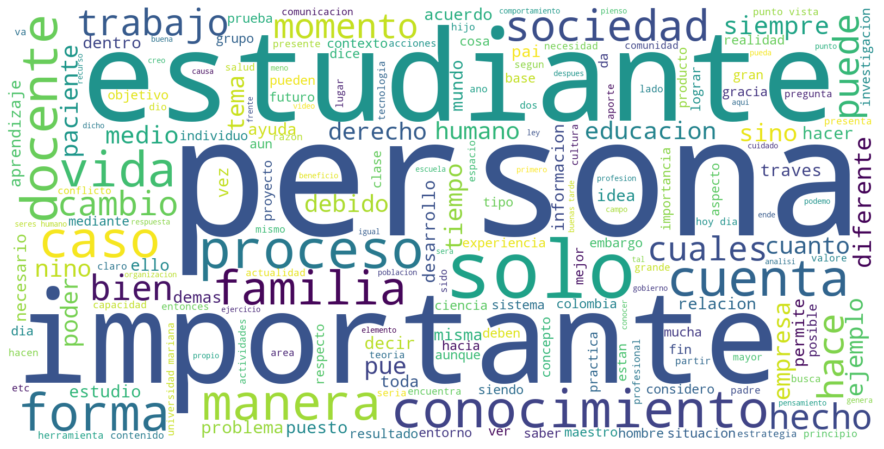

In [ ]:
#Dividir en palabras y eliminar palabras vacias
train_data['tokenized'] = train_data['cleaned'].apply(tokenize_text)

#Imprimir nube de palabras sin stop words
def to_doc(words:tuple) -> spacy.tokens.Doc:
    return ' '.join(words)

train_data['tokens_string'] = train_data['tokenized'].apply(to_doc)

dataset_stw = [x for x in train_data['tokens_string']]
dataset_stw = ' '.join(dataset_stw)

#Imprimir nube de palabras
print(f"*****Nube de Palabras ***** \n", "\n")
wordcloud = WordCloud(
    background_color='white',
    width=1600, height=800).generate(dataset_stw)
plt.figure( figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
train_data.head()

,texto,sentiment,cleaned,lang,tokenized,tokens_string
0,<p>Este espacio esta creado para conocer a los participantes en el curso.</p><p>Por favor haga su presentación.<br></p>,0,este espacio esta creado para conocer a los participantes en el cursopor favor haga su presentacion,es,"[espacio, creado, conocer, participantes, cursopor, favor, haga, presentacion]",espacio creado conocer participantes cursopor favor haga presentacion
1,"<p>Te invito a que comentes tus expectativas que tienes sobre este curso. Para ello, adjunto los temas a abordar. Deja tu opinión en este foro, y comenta al menos una opinión de tus compañeros. Recuerda, todo dentro del marco del respeto por las opiniones de los demás.</p>",0,te invito a que comentes tus expectativas que tienes sobre este curso para ello adjunto los temas a abordar deja tu opinion en este foro y comenta al menos una opinion de tus companeros recuerda todo dentro del marco del respeto por las opiniones de los demas,es,"[invito, comentes, expectativas, curso, ello, adjunto, temas, abordar, deja, opinion, foro, comenta, menos, opinion, companeros, recuerda, dentro, marco, respeto, opiniones, demas]",invito comentes expectativas curso ello adjunto temas abordar deja opinion foro comenta menos opinion companeros recuerda dentro marco respeto opiniones demas
2,tener y ahondar mas los conocimientos de ingles para así poder tener mas conocimientos de los temas expuestos de los temas &nbsp;en el curso de ingles,0,tener y ahondar mas los conocimientos de ingles para asi poder tener mas conocimientos de los temas expuestos de los temas en el curso de ingles,es,"[ahondar, conocimientos, ingles, poder, conocimientos, temas, expuestos, temas, curso, ingles]",ahondar conocimientos ingles poder conocimientos temas expuestos temas curso ingles
3,tener una buena base de ingles I para así poder empezar con lecturas muy cortas y luego ir avanzando hasta poder defenderse en el ingles.,0,tener una buena base de ingles i para asi poder empezar con lecturas muy cortas y luego ir avanzando hasta poder defenderse en el ingles,es,"[buena, base, ingles, i, poder, empezar, lecturas, cortas, luego, ir, avanzando, poder, defenderse, ingles]",buena base ingles i poder empezar lecturas cortas luego ir avanzando poder defenderse ingles
4,<p>Mis expectativas para este curso es poder reforzar mis bases de ingles adquiridas en cursos anteriores &nbsp;en los cuales no le he tenido mucho amor a el ingles y en este curso espero poder colega gusto a el idioma y aprenderlo mucho mejor ya que se esta convirtiendo en un idioma muy importante</p>,0,mis expectativas para este curso es poder reforzar mis bases de ingles adquiridas en cursos anteriores en los cuales no le he tenido mucho amor a el ingles y en este curso espero poder colega gusto a el idioma y aprenderlo mucho mejor ya que se esta convirtiendo en un idioma muy importante,es,"[expectativas, curso, poder, reforzar, bases, ingles, adquiridas, cursos, anteriores, cuales, amor, ingles, curso, espero, poder, colega, gusto, idioma, aprenderlo, mejor, convirtiendo, idioma, importante]",expectativas curso poder reforzar bases ingles adquiridas cursos anteriores cuales amor ingles curso espero poder colega gusto idioma aprenderlo mejor convirtiendo idioma importante


Etiquetar el sentimiento del texto de los foros

*Buscar los lemas * 

In [ ]:
nlp = spacy.load('es_core_news_sm')

def to_doc(words:tuple) -> spacy.tokens.Doc:
    return nlp(' '.join(words))

def lemmatize(doc) -> list:
    return [token.lemma_ for token in doc if token not in {'temas'}]

docs = list(map(to_doc, train_data.tokenized))
train_data['lemmatized'] = list(map(lemmatize, docs))

#train_data['stemmed'] = train_data['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x])

In [ ]:
train_data.head()


,texto,sentiment,cleaned,lang,tokenized,tokens_string,lemmatized
0,<p>Este espacio esta creado para conocer a los participantes en el curso.</p><p>Por favor haga su presentación.<br></p>,0,este espacio esta creado para conocer a los participantes en el cursopor favor haga su presentacion,es,"[espacio, creado, conocer, participantes, cursopor, favor, haga, presentacion]",espacio creado conocer participantes cursopor favor haga presentacion,"[espaciar, crear, conocer, participante, cursopor, favor, hacer, presentacion]"
1,"<p>Te invito a que comentes tus expectativas que tienes sobre este curso. Para ello, adjunto los temas a abordar. Deja tu opinión en este foro, y comenta al menos una opinión de tus compañeros. Recuerda, todo dentro del marco del respeto por las opiniones de los demás.</p>",0,te invito a que comentes tus expectativas que tienes sobre este curso para ello adjunto los temas a abordar deja tu opinion en este foro y comenta al menos una opinion de tus companeros recuerda todo dentro del marco del respeto por las opiniones de los demas,es,"[invito, comentes, expectativas, curso, ello, adjunto, temas, abordar, deja, opinion, foro, comenta, menos, opinion, companeros, recuerda, dentro, marco, respeto, opiniones, demas]",invito comentes expectativas curso ello adjunto temas abordar deja opinion foro comenta menos opinion companeros recuerda dentro marco respeto opiniones demas,"[invitar, comentar, expectativa, cursar, él, adjuntar, temer, abordar, dejar, opinion, foro, comentar, menos, opinion, companeros, recordar, dentro, marcar, respetar, opinión, demas]"
2,tener y ahondar mas los conocimientos de ingles para así poder tener mas conocimientos de los temas expuestos de los temas &nbsp;en el curso de ingles,0,tener y ahondar mas los conocimientos de ingles para asi poder tener mas conocimientos de los temas expuestos de los temas en el curso de ingles,es,"[ahondar, conocimientos, ingles, poder, conocimientos, temas, expuestos, temas, curso, ingles]",ahondar conocimientos ingles poder conocimientos temas expuestos temas curso ingles,"[ahondar, conocimiento, ingle, poder, conocimiento, temer, exponer, temer, cursar, ingle]"
3,tener una buena base de ingles I para así poder empezar con lecturas muy cortas y luego ir avanzando hasta poder defenderse en el ingles.,0,tener una buena base de ingles i para asi poder empezar con lecturas muy cortas y luego ir avanzando hasta poder defenderse en el ingles,es,"[buena, base, ingles, i, poder, empezar, lecturas, cortas, luego, ir, avanzando, poder, defenderse, ingles]",buena base ingles i poder empezar lecturas cortas luego ir avanzando poder defenderse ingles,"[bueno, basar, ingle, i, poder, empezar, lectura, corto, luego, ir, avanzar, poder, defenderse, ingle]"
4,<p>Mis expectativas para este curso es poder reforzar mis bases de ingles adquiridas en cursos anteriores &nbsp;en los cuales no le he tenido mucho amor a el ingles y en este curso espero poder colega gusto a el idioma y aprenderlo mucho mejor ya que se esta convirtiendo en un idioma muy importante</p>,0,mis expectativas para este curso es poder reforzar mis bases de ingles adquiridas en cursos anteriores en los cuales no le he tenido mucho amor a el ingles y en este curso espero poder colega gusto a el idioma y aprenderlo mucho mejor ya que se esta convirtiendo en un idioma muy importante,es,"[expectativas, curso, poder, reforzar, bases, ingles, adquiridas, cursos, anteriores, cuales, amor, ingles, curso, espero, poder, colega, gusto, idioma, aprenderlo, mejor, convirtiendo, idioma, importante]",expectativas curso poder reforzar bases ingles adquiridas cursos anteriores cuales amor ingles curso espero poder colega gusto idioma aprenderlo mejor convirtiendo idioma importante,"[expectativa, cursar, poder, reforzar, base, ingle, adquirir, curso, anterior, cual, amor, ingle, cursar, esperar, poder, colega, gustar, idioma, aprenderlo, mejor, convertir, idioma, importante]"


Cargar archivos de palabras positivas y negativas

In [ ]:
with open("/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/positive_words_es.txt") as f:
    pos_words = f.readlines()
    pos_words = [x.strip() for x in pos_words] 
    
with open("/content/gdrive/My Drive/TFM_Analisis_Sentimientos/Corpus/negative_words_es.txt") as f:
    neg_words = f.readlines()
    neg_words = [x.strip() for x in neg_words] 

Función para predecir sentimiento

In [ ]:
def sentiment_score(doc):
  y_pred = []
  for sentence in doc:
    pos_score = 0
    words = sentence.split()
    for word in words:
        if word in pos_words:           
            pos_score += 1
        if word in neg_words:          
            pos_score -= 1
   
    if pos_score > 0:
        return 'POSITIVO'
    elif pos_score < 0:
        return 'NEGATIVO'
    else:
        return 'NEUTRAL'       
    return pos_score

def source_data(row):
  return 'FORO'

train_data['sentiment'] = train_data['lemmatized'].apply(sentiment_score)
train_data['source'] = train_data.apply(source_data,axis=1)


In [ ]:
train_data.sample(5)

,texto,sentiment,cleaned,lang,tokenized,tokens_string,lemmatized,source
17489,"<p>Teniendo en cuenta que el paradigma cualitativo se interesa en comprender la conducta del ser humano en el actuar cotidiano y el paradigma cuantitativo busca las causas de los fenómenos a través de la recolección y análisis de datos. Los paradigmas son un camino que nos ayudaran a desarrollar los procesos investigativos que de acuerdo a nuestras ideas y orientación en la forma de abarcar, abordar y ampliar los métodos en una investigación, donde cada uno de los paradigmas desarrolla aspectos importantes en una investigación.</p><p>El paradigma cualitativo nos lleva a transformar a las personas porque la misma sociedad está en continuo cambio y eso quiere decir que el paradigma no debe ser rígido, por el contrario debe flexibilizase para adaptarse y centrarse en los cambios para cambiar su perspectiva.</p>",NEUTRAL,teniendo en cuenta que el paradigma cualitativo se interesa en comprender la conducta del ser humano en el actuar cotidiano y el paradigma cuantitativo busca las causas de los fenomenos a traves de la recoleccion y analisis de datos los paradigmas son un camino que nos ayudaran a desarrollar los procesos investigativos que de acuerdo a nuestras ideas y orientacion en la forma de abarcar abordar y ampliar los metodos en una investigacion donde cada uno de los paradigmas desarrolla aspectos importantes en una investigacionel paradigma cualitativo nos lleva a transformar a las personas porque la misma sociedad esta en continuo cambio y eso quiere decir que el paradigma no debe ser rigido por el contrario debe flexibilizase para adaptarse y centrarse en los cambios para cambiar su perspectiva,es,"[cuenta, paradigma, cualitativo, interesa, comprender, conducta, humano, actuar, cotidiano, paradigma, cuantitativo, busca, causas, fenomenos, traves, recoleccion, analisis, datos, paradigmas, camino, ayudaran, desarrollar, procesos, investigativos, acuerdo, ideas, orientacion, forma, abarcar, abordar, ampliar, metodos, investigacion, paradigmas, desarrolla, aspectos, importantes, investigacionel, paradigma, cualitativo, lleva, transformar, personas, misma, sociedad, continuo, cambio, quiere, decir, paradigma, rigido, contrario, flexibilizase, adaptarse, centrarse, cambios, cambiar, perspectiva]",cuenta paradigma cualitativo interesa comprender conducta humano actuar cotidiano paradigma cuantitativo busca causas fenomenos traves recoleccion analisis datos paradigmas camino ayudaran desarrollar procesos investigativos acuerdo ideas orientacion forma abarcar abordar ampliar metodos investigacion paradigmas desarrolla aspectos importantes investigacionel paradigma cualitativo lleva transformar personas misma sociedad continuo cambio quiere decir paradigma rigido contrario flexibilizase adaptarse centrarse cambios cambiar perspectiva,"[contar, paradigma, cualitativo, interesar, comprender, conducta, humanar, actuar, cotidiano, paradigma, cuantitativo, buscar, causar, fenomenos, traves, recoleccion, analisis, dato, paradigma, caminar, ayudar, desarrollar, proceso, investigativos, acordar, ideo, orientacion, formar, abarcar, abordar, ampliar, metodos, investigacion, paradigma, desarrollar, aspecto, importante, investigacionel, paradigma, cualitativo, llevar, transformar, personar, mismo, sociedad, continuo, cambiar, querer, decir, paradigma, rigido, contrario, flexibilizar, adaptarse, centrarse, cambio, cambiar, perspectivo]",FORO
21328,<p>Doctora Alejandra</p><p> </p><p>Buenos Dias por favor me recuerda el correo para compartir la actividad</p><p> </p><p>Mil gracias</p><p> </p><p> </p><p>Maria E. Narvaez</p><p> </p>,NEUTRAL,doctora alejandra buenos dias por favor me recuerda el correo para compartir la actividad mil gracias maria e narvaez,es,"[doctora, alejandra, buenos, dias, favor, recuerda, correo, compartir, actividad, mil, gracias, maria, narvaez]",doctora alejandra buenos dias favor recuerda correo compartir actividad mil gracias maria narvaez,"[

NEUTRAL     22872
POSITIVO    7359 
NEGATIVO    1853 
Name: sentiment, dtype: int64


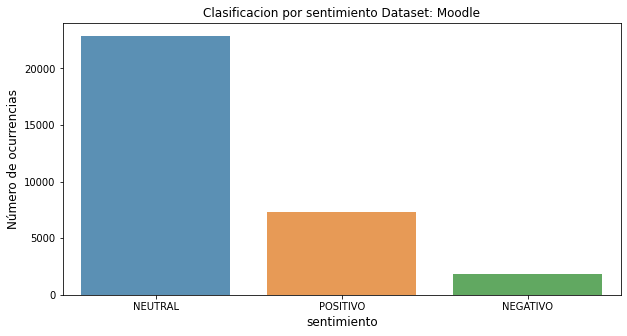

In [ ]:
#Analizar el dataset
#print(train_data["rating"].value_counts())
print(train_data["sentiment"].value_counts())
lang_count  = train_data["sentiment"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(lang_count.index, lang_count.values, alpha=0.8)
plt.title('Clasificacion por sentimiento Dataset: Moodle')
plt.ylabel('Número de ocurrencias', fontsize=12)
plt.xlabel('sentimiento', fontsize=12)
plt.show()



In [ ]:
print(train_data["sentiment"].value_counts())
train_data.to_csv('dataset_1_moodle.csv',columns=['cleaned','sentiment','source'])

NEUTRAL     22872
POSITIVO    7359 
NEGATIVO    1853 
Name: sentiment, dtype: int64
